In [1]:
# Show figure where we try to predict immune escape from vaccination
# Need to simulate vaccination rates and then ODE model / frequencies based on that
# Then estimate growth advantages



In [2]:
from functools import partial
import jax
from jax import grad, jit, lax, random, vmap
import jax.numpy as jnp
import numpy as np
import jax.scipy as scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import linregress
from jax.experimental.ode import odeint

In [3]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from ode_models import two_variant_model

In [4]:
SEED = 11 * 2 * 2021
key = random.PRNGKey(SEED)
key, subkey = random.split(key)

In [5]:

# Defining model parameters
R0_wt = 1.4 # Basic reproduction number in wild type
rho = 0.5

R0_v = (1+rho) * R0_wt # Basic reproduction number in variant

gen_wt = 3.0 # Average length of infection (days): 1 / gam_wt
gen_v = 3.0 # (...):  1 / gam_v
eta_E = 0.0 # Escape fraction

# Rest of quantities can be computed from the above
gam_wt =  1 / gen_wt
beta_wt = R0_wt * gam_wt

gam_v = 1 / gen_v
beta_v = R0_v * gam_v

eta_gam = gam_v / gam_wt
eta_T = beta_v / beta_wt

In [6]:
beta_v

0.6999999999999998

In [93]:
#  Defining parameters and initial conditions
true_θ = (beta_wt, gam_wt, eta_T, eta_E, eta_gam)

# Simulate
V0s = np.array([0.0, 0.2, 0.4, 0.6, 0.8])
V0s = np.linspace(0.05, min(1-1 / R0_v + 0.1, 0.95), 11)
V0s = np.linspace(0.00, 0.65, 14)

Y_dict = dict()

Iwt0 = 1e-3
Iv0 = 1e-5
N = 100_000

for v, V0 in enumerate(V0s):
    u0 = jnp.array([1.0 - V0 - Iwt0 - Iv0, Iwt0, Iv0, V0, 0.0, 0.0, 0.0])
    t = jnp.arange(100.)
    Y_dict[v] = odeint(two_variant_model, u0, t, true_θ, atol=1e-10)

In [94]:
cmap = plt.get_cmap('viridis')

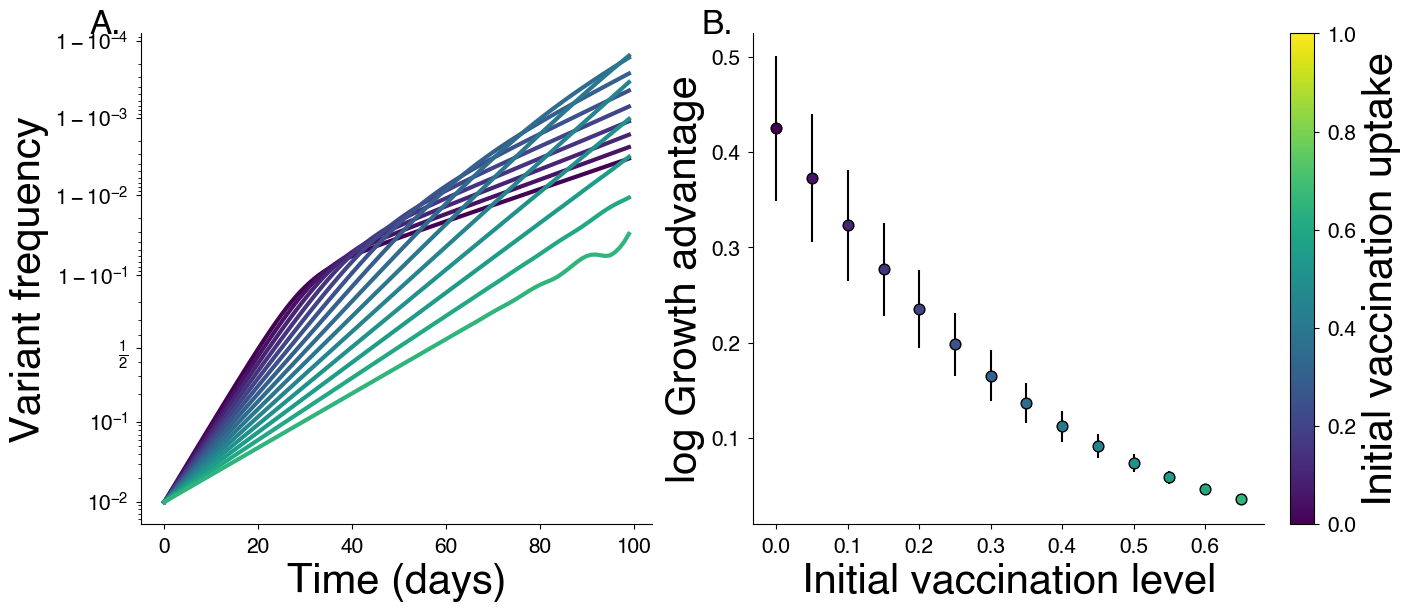

In [95]:
fig = plt.figure(figsize=(14., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)

# Plot variant frequencies
ax0 = fig.add_subplot(spec[0, 0])
for v, V0 in enumerate(np.array(V0s)):
    frac_v = Y_dict[v][:, 2] /  (Y_dict[v][:, 1] + Y_dict[v][:, 2]) 
    ax0.plot(t, frac_v, color = cmap(V0), linewidth=3.0)
    
ax0.set_ylabel("Variant frequency")
ax0.set_xlabel("Time (days)")
ax0.set_ylabel("Variant frequency")
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.set_yscale("logit")

# Plot growth advantage
def get_growth_advantage(frac_v):
    logit_frac = np.log(frac_v / (1-frac_v))
    times = np.arange(len(frac_v)) / len(frac_v)
    model = linregress(times, frac_v)
    return model.slope, model.stderr

ax1 = fig.add_subplot(spec[0, 1])
gas = []
ga_stds = []
for v, V0 in enumerate(np.array(V0s)):
    frac_v = Y_dict[v][:, 2] /  (Y_dict[v][:, 1] + Y_dict[v][:, 2]) 
    ga, ga_stderr = get_growth_advantage(frac_v[:20])
    ax1.scatter([V0], ga, color = cmap(V0), linewidth=1.0, ec="k", s=60.)
    ax1.errorbar([V0], ga, yerr=ga_stderr*1.96, color = "k", linewidth=1.5, zorder=-4)
    gas.append(ga)
    ga_stds.append(ga_stderr)

# Plot linear regression of V0s and gas
ax1.set_xlabel("Initial vaccination level")
ax1.set_ylabel("log Growth advantage")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

colorbar = fig.colorbar(cm.ScalarMappable(None, cmap), ax=ax1)
colorbar.set_label("Initial vaccination uptake")

axes = [ax0, ax1]
ax_labels = ["A", "B"]

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.0, ax_label + ".", transform=ax.transAxes, size=24, weight='bold')
    

# Even in the absence of immune mediated selection
# You can still have correlation between vaccinated proprortion and selective advantage.

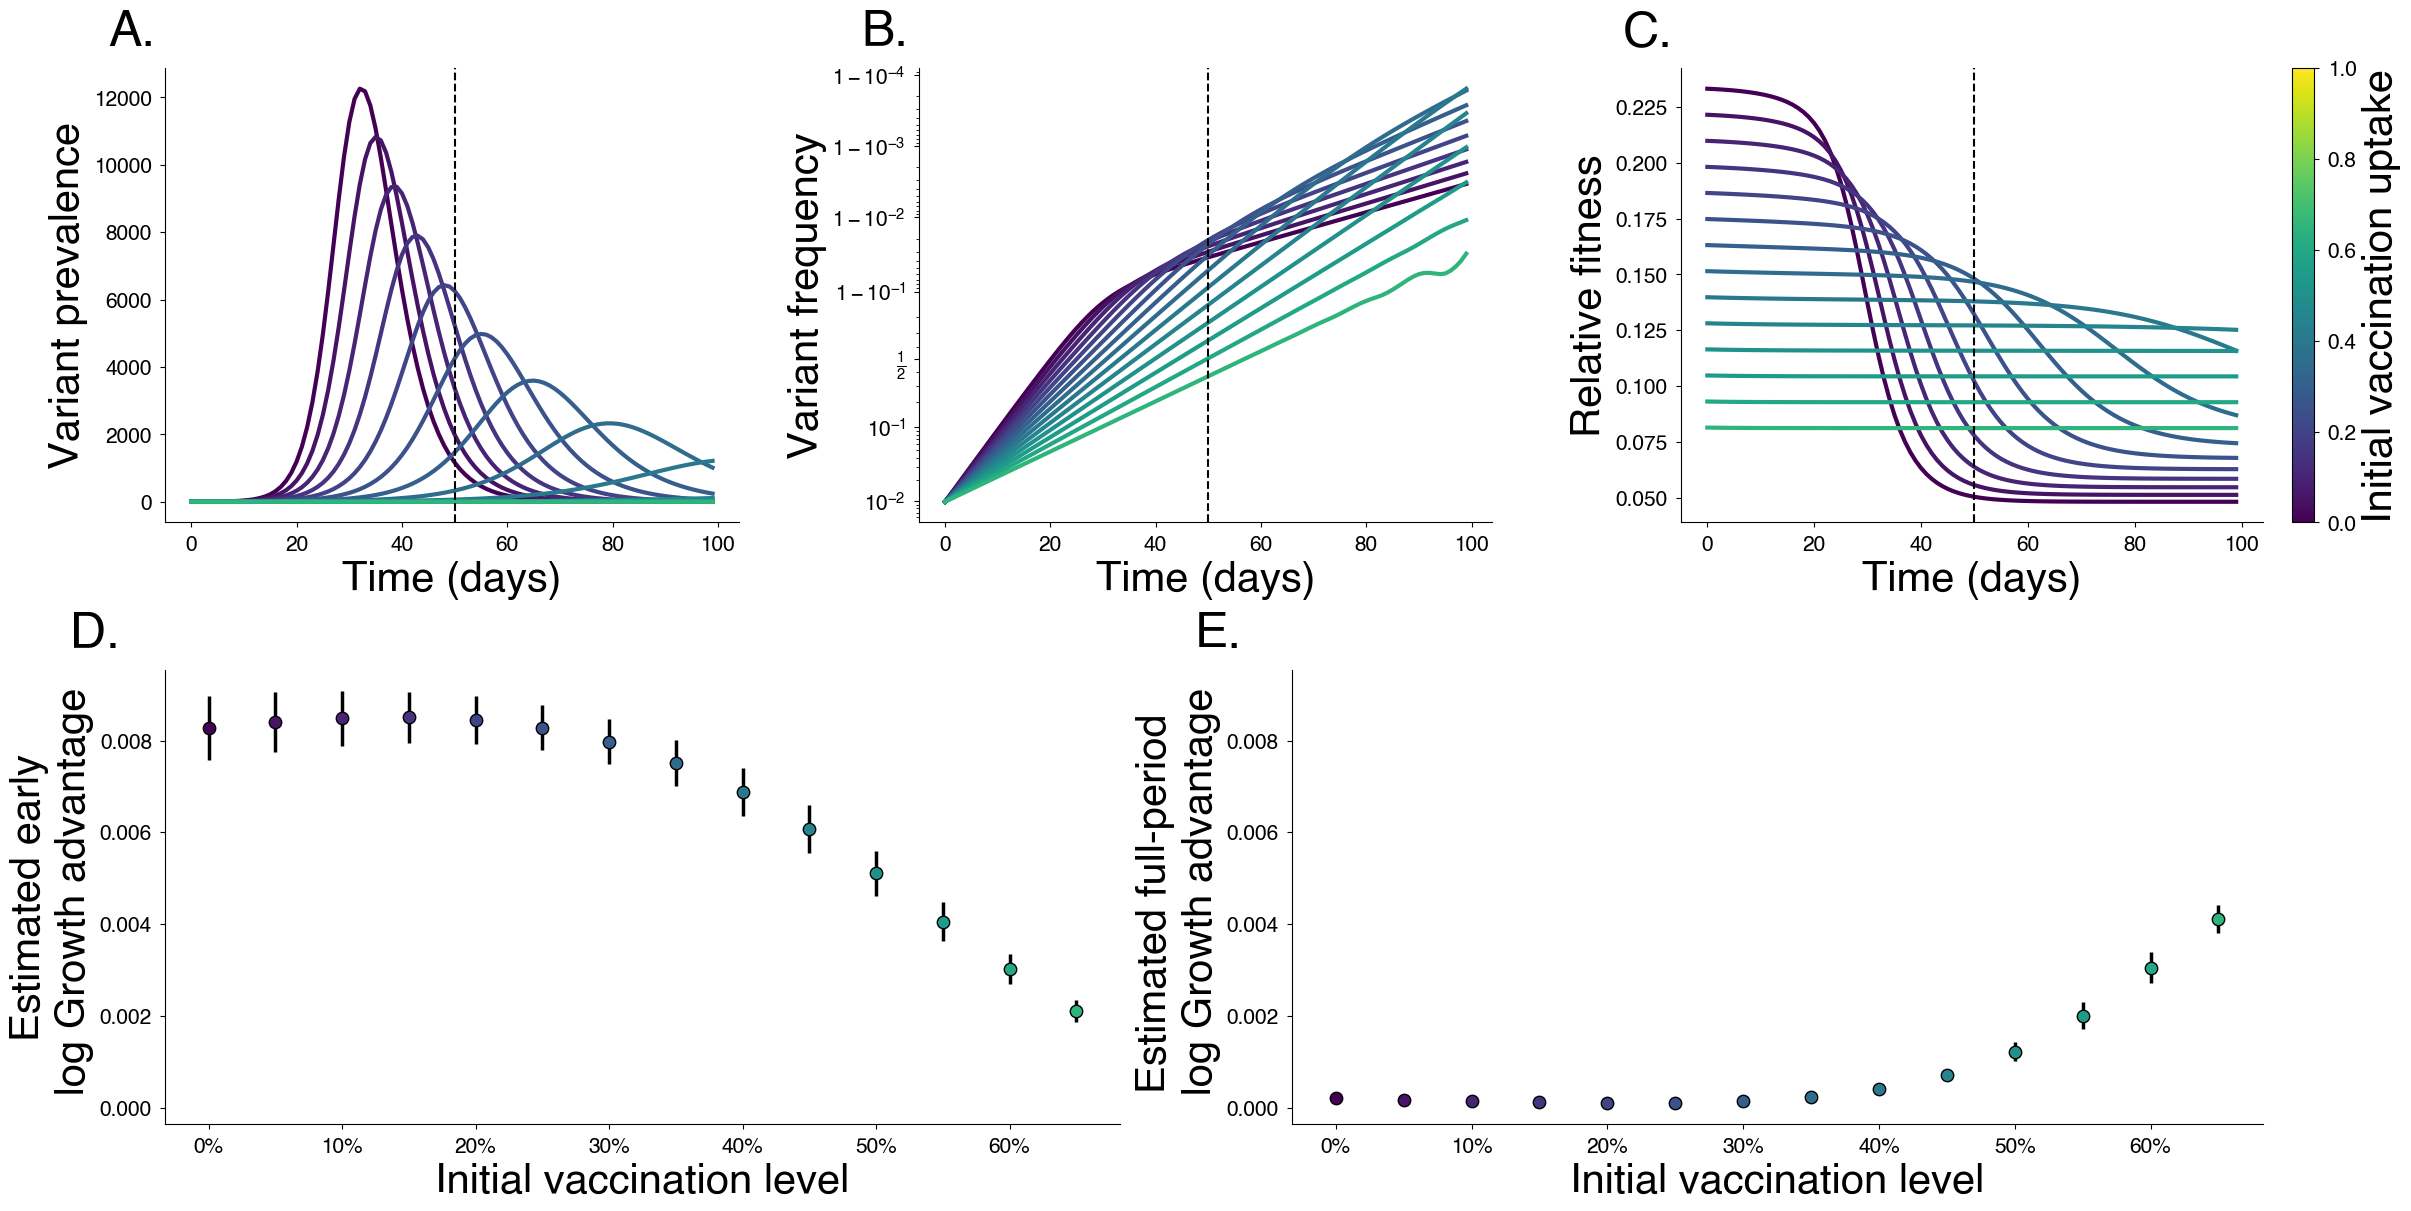

In [99]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(24., 12), constrained_layout=True)
spec = fig.add_gridspec(ncols=6, nrows=2)

# Labeling
early_cutoff = 50

# Plot variant frequencies
ax_freq = fig.add_subplot(spec[0, 2:4])
for v, V0 in enumerate(np.array(V0s)):
    frac_v = Y_dict[v][:, 2] /  (Y_dict[v][:, 1] + Y_dict[v][:, 2]) 
    ax_freq.plot(t, frac_v, color = cmap(V0), linewidth=3.0)
ax_freq.axvline(x=early_cutoff, color="k", linewidth=1.5, linestyle="--")    
ax_freq.set_ylabel("Variant frequency")
ax_freq.set_xlabel("Time (days)")
ax_freq.spines['top'].set_visible(False)
ax_freq.spines['right'].set_visible(False)
ax_freq.set_yscale("logit")

# Plot variant prevalence
ax_inf = fig.add_subplot(spec[0, 0:2])
for v, V0 in enumerate(np.array(V0s)):
    inf_v = Y_dict[v][:, 2]
    ax_inf.plot(t, N * inf_v, color = cmap(V0), linewidth=3.0)
    
ax_inf.axvline(x=early_cutoff, color="k", linewidth=1.5, linestyle="--")    
ax_inf.set_ylabel("Variant prevalence")
ax_inf.set_xlabel("Time (days)")
ax_inf.spines['top'].set_visible(False)
ax_inf.spines['right'].set_visible(False)

# Plot true relative fitnesses over time
ax_rel_fit = fig.add_subplot(spec[0, 4:6])
for v, V0 in enumerate(np.array(V0s)):
    true_relative_fitness = (beta_v - beta_wt) * Y_dict[v][:, 0]
    ax_rel_fit.plot(t, true_relative_fitness, color = cmap(V0), linewidth=3.0)
ax_rel_fit.axvline(x=early_cutoff, color="k", linewidth=1.5, linestyle="--")    
ax_rel_fit.set_ylabel("Relative fitness")
ax_rel_fit.set_xlabel("Time (days)")
ax_rel_fit.spines['top'].set_visible(False)
ax_rel_fit.spines['right'].set_visible(False)


# Plot estimated early growth advantage
def get_growth_advantage(frac_v, t):
    logit_frac = np.log(frac_v / (1-frac_v))
    times = t * gen_v
    model = linregress(times, frac_v)
    return model.slope, model.stderr

# Plot linear regression of V0s and gas
ax_early_ga = fig.add_subplot(spec[1, 0:3])
gas = []
ga_stds = []

for v, V0 in enumerate(np.array(V0s)):
    frac_v = Y_dict[v][:, 2] /  (Y_dict[v][:, 1] + Y_dict[v][:, 2]) 
    ga, ga_stderr = get_growth_advantage(frac_v[:early_cutoff], t[:early_cutoff])
    ax_early_ga.scatter([V0], ga, color = cmap(V0), linewidth=1.0, ec="k", s=80.)
    ax_early_ga.errorbar([V0], ga, yerr=ga_stderr*1.96, color = "k", linewidth=2.5, zorder=-4)
    gas.append(ga)
    ga_stds.append(ga_stderr)

ax_early_ga.set_xlabel("Initial vaccination level")
ax_early_ga.set_ylabel("Estimated early\n log Growth advantage")
ax_early_ga.spines['top'].set_visible(False)
ax_early_ga.spines['right'].set_visible(False)
ax_early_ga.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Plot growth advantage over whole range
ax_full_ga = fig.add_subplot(spec[1, 3:6], sharey=ax_early_ga)
gas = []
ga_stds = []

for v, V0 in enumerate(np.array(V0s)):
    frac_v = Y_dict[v][:, 2] /  (Y_dict[v][:, 1] + Y_dict[v][:, 2]) 
    ga, ga_stderr = get_growth_advantage(frac_v[early_cutoff:], t[early_cutoff:])
    ax_full_ga.scatter([V0], ga, color = cmap(V0), linewidth=1.0, ec="k", s=80.)
    ax_full_ga.errorbar([V0], ga, yerr=ga_stderr*1.96, color = "k", linewidth=2.5, zorder=-4)
    gas.append(ga)
    ga_stds.append(ga_stderr)

ax_full_ga.set_xlabel("Initial vaccination level")
ax_full_ga.set_ylabel("Estimated full-period \n log Growth advantage")
ax_full_ga.spines['top'].set_visible(False)
ax_full_ga.spines['right'].set_visible(False)
ax_full_ga.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
#ax_full_ga.axvline(x=1 - 1/R0_v, color="grey", linewidth=2.5, linestyle="--")    
#ax_full_ga.annotate(r"$1-\frac{1}{R_{v}}$", (1 -1/R0_v + 0.02, 0.001), size=18)    


colorbar = fig.colorbar(cm.ScalarMappable(None, cmap), ax=ax_rel_fit)
colorbar.set_label("Initial vaccination uptake")

axes = [ax_inf,ax_freq, ax_rel_fit, ax_early_ga, ax_full_ga]
ax_labels = ["A", "B", "C", "D", "E"]

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
    
fig.savefig("../manuscript/figures/" + "mechanism_identification.png")
# Even in the absence of immune mediated selection
# You can still have correlation between vaccinated proprortion and selective advantage.